In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
from ca_acquisition import ca_acquisition
from ca import reference_signal
import math

In [3]:
#parâmetros
fs = 4e6
T_d = 1e-3
f_seq = 1.023e6
Ts = 1/fs
Tc = 1/f_seq
f_c = 1575.42e6
num_periods = 1
Delta = 0.5*Tc
K = 500
N = num_periods*fs*T_d
N_acq = fs*T_d
index_sample_in = 100*N

In [4]:
#Importando o valor de x do matlab
x_mat = loadmat('xacq.mat') 
x = x_mat["X"]

In [5]:
#Importando o valor de index_sample_out do matlab
index_sample_out_mat = loadmat('index_sample_out.mat')
index_sample_out_ = index_sample_out_mat["index_sample_out"]
index_sample_out = int(index_sample_out_[0]) #No matlab a variável é um inteiro, mas a importação se deu como ndarray aí fiz a conversão

In [6]:
#Parâmetros do sinal
delay = np.array(np.zeros((500,7)))
error_signal_delay = np.array(np.zeros((500,7)))
corr_early = np.array(np.zeros((499,7)),dtype=complex)
corr_late = np.array(np.zeros((499,7)),dtype=complex)
corr_prompt = np.array(np.zeros((499,7)),dtype=complex)
doppler = np.array(np.zeros((500,7)))
phase_doppler = np.array(np.zeros((500,7)))
#x_d_H = np.array(np.zeros((400,1)))
Q = np.array(np.zeros((499,7)))
I = np.array(np.zeros((499,7)))
phase = np.array(np.zeros((500,7)))
error_signal_phase = np.array(np.zeros((499,7)))
error_signal_doppler = np.array(np.zeros((499,7)))

In [7]:
#t= np.arange(0,(N-0.5)*Ts,Ts)
t_mat = loadmat('t.mat')
t = t_mat["t"][0]

In [8]:
(ACQ_DATA,doppler_bin_vec,threshold,sats_found)=ca_acquisition(t[0:int(N_acq)],x[0,0:int(N_acq)],fs,f_seq,1)

In [9]:
for k in range(1,K):
    for m in range(len(sats_found)):
        delay[0,:] = [8.7825e-04, 9.8425e-04, 6.2775e-04, 6.5025e-04, 3.2800e-04, 6.9975e-04, 8.8750e-05] #ACQ_DATA['data'][sats_found[m]-1][1]*Ts 
        doppler[0,:] = [-2700, 1700, -3000, -100, -100, 2000, 700] #doppler_bin_vec[ACQ_DATA['data'][sats_found[m]-1][0]]

In [10]:
for k in range(1,K):
    for m in range(len(sats_found)):
        #doppler
        x_d_H = np.conjugate(x[k-1,:])*(np.exp(1j*(phase_doppler[k-1,m]+2*np.pi*doppler[k-1,m]*t)))
        
        #correlatores
        delay_early = delay[k-1,m]+Delta
        delay_late = delay[k-1,m]-Delta
        delay_prompt = delay[k-1,m]

        ref_early = reference_signal(sats_found[m], delay_early,f_seq,fs,num_periods)
        ref_late = reference_signal(sats_found[m], delay_late,f_seq,fs,num_periods)
        ref_prompt = reference_signal(sats_found[m], delay_prompt,f_seq,fs,num_periods)

        corr_early[k-1,m] = np.inner(x_d_H,ref_early)/N
        corr_late[k-1,m] = np.inner(x_d_H,ref_late)/N
        corr_prompt[k-1,m] = np.inner(x_d_H,ref_prompt)/N

        #DLL
        error_signal_delay[k-1,m]=np.abs(corr_early[k-1,m])**2-np.abs(corr_late[k-1,m])**2

        #DLL de primeira ordem
        K_tau = Tc/(2*np.abs(corr_prompt[k-1,m])**2)
        K_tau_1 = 0.03
        a_tau_0 = K_tau_1
        B_tau_1 = K_tau_1/(2*(2-K_tau_1))/T_d
        delay[k,m] = delay[k-1,m]+K_tau*a_tau_0*error_signal_delay[k-1,m] 

        #PLL
        Q[k-1,m] = np.imag(corr_prompt[k-1,m]*np.exp(1j*phase[k-1,m]))
        I[k-1,m] = np.real(corr_prompt[k-1,m]*np.exp(1j*phase[k-1,m]))

        error_signal_phase[k-1,m] = -np.arctan(Q[k-1,m]/I[k-1,m])

        if k<2:
            phase[k,m] = phase[k-1,m]+0.5*error_signal_phase[k-1,m]
        else:
            K_phi_1 = 0.438
            K_phi_2 = 0.00626
            K_phi = 1
            a_phi_0 = K_phi_1 + K_phi_2
            a_phi_1 = K_phi_2
            B_phi_2 = ((2*(K_phi_1**2)*2*K_phi_2+K_phi_1*K_phi_2)/(2*K_phi_1*(4-2*K_phi_1-K_phi_2)))/T_d
            phase[k,m] = 2*phase[k-1,m]-phase[k-2,m]+a_phi_0*K_phi*error_signal_phase[k-1,m]+K_phi*(a_phi_1-a_phi_0)*error_signal_phase[k-2,m]
        
        if k<3:
            doppler[k,m] = doppler[k-1,m]
            error_signal_doppler[k-1,m] = 0
        else:
            disc_nu = -math.atan2((np.imag(corr_prompt[k-1,m])*np.real(corr_prompt[k-2,m]))- (np.imag(corr_prompt[k-2,m])*np.real(corr_prompt[k-1,m])),(np.real(corr_prompt[k-1,m])*np.real(corr_prompt[k-2,m]))+(np.imag(corr_prompt[k-1,m])*np.imag(corr_prompt[k-2,m])))
            error_signal_doppler[k-1,m] = disc_nu/(2*np.pi*num_periods*T_d)

            #FLL 
            K_nu_1=0.002903
            K_nu_2=2.812e-6
            K_nu_3=9.084e-10
            K_nu=1; #tuning
            a_nu_0=(K_nu_1+K_nu_2+K_nu_3)
            a_nu_1=(K_nu_2+2*K_nu_3)
            a_nu_2= K_nu_3
            doppler[k,m]=3*doppler[k-1,m]-3*doppler[k-2,m]+doppler[k-3,m]+a_nu_0*K_nu*error_signal_doppler[k-1,m]+K_nu*(a_nu_1-2*a_nu_0)*error_signal_doppler[k-2,m]+K_nu*(a_nu_0-a_nu_1)*error_signal_doppler[k-3,m]
        
        phase_doppler[k,m] = phase_doppler[k-1,m]+2*np.pi*doppler[k,m]*T_d         





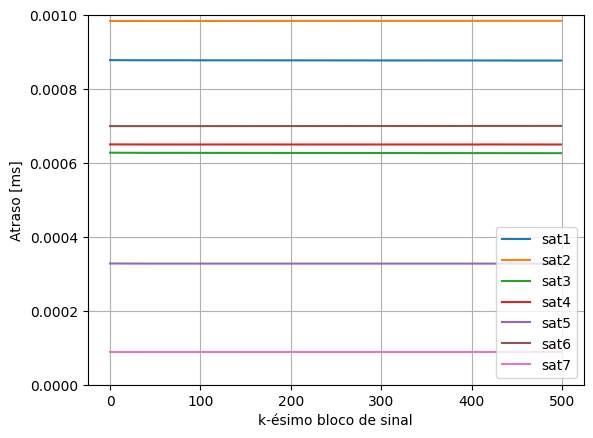

In [12]:
plt.plot(delay)
plt.ylim(0,1e-3)
plt.xlabel("k-ésimo bloco de sinal")
plt.ylabel("Atraso [ms]")
plt.legend(["sat1","sat2","sat3","sat4","sat5","sat6","sat7" ], loc="lower right")
plt.grid(True)

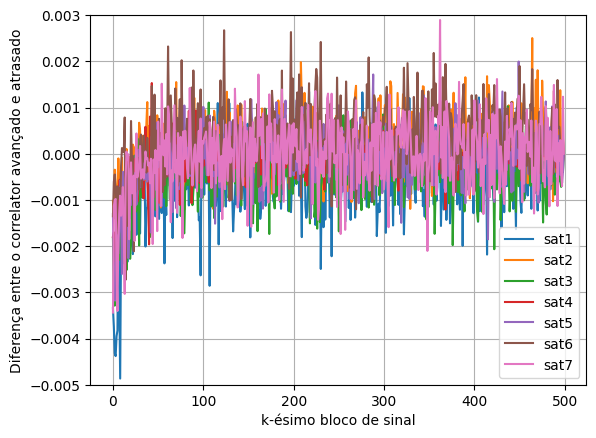

In [38]:
plt.plot(error_signal_delay)
plt.ylim([-5e-3,3e-3])
#plt.xlim([400,500])
plt.legend(["sat1","sat2","sat3","sat4","sat5","sat6","sat7" ])
plt.xlabel("k-ésimo bloco de sinal")
plt.ylabel("Diferença entre o correlator avançado e atrasado")
plt.grid(True)

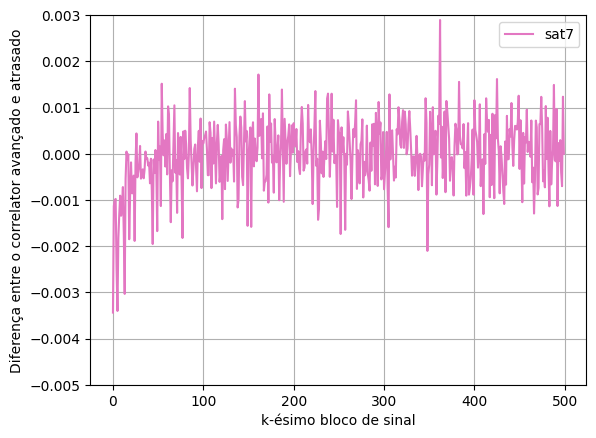

In [74]:
plt.plot(error_signal_delay[:,6],'tab:pink')
plt.ylim([-5e-3,3e-3])
#plt.xlim([400,500])
plt.xlabel("k-ésimo bloco de sinal")
plt.ylabel("Diferença entre o correlator avançado e atrasado")
plt.legend(["sat7"], loc='upper right')
plt.grid(True)

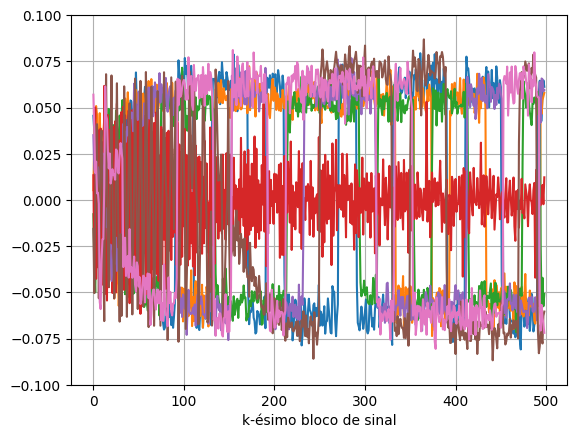

In [35]:
plt.plot(I)
plt.ylim(-0.1,0.1)
plt.xlabel("k-ésimo bloco de sinal")
plt.ylabel("")
plt.grid(True)

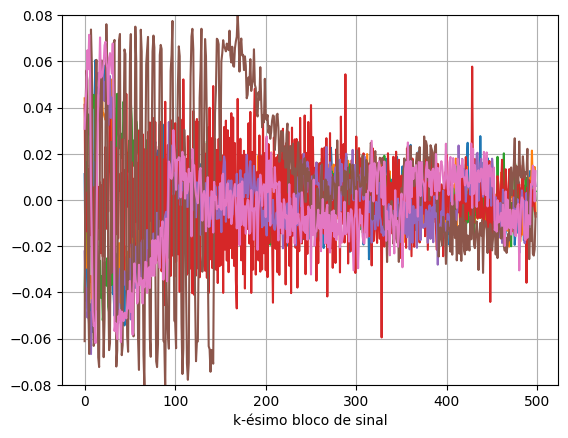

In [34]:
plt.plot(Q)
plt.ylim(-0.08,0.08)
plt.xlabel("k-ésimo bloco de sinal")
plt.ylabel("")
plt.grid(True)

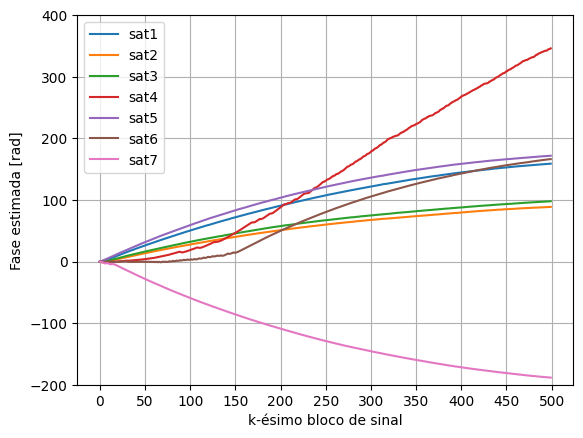

In [75]:
plt.plot(phase)
plt.ylim(-200,400)
plt.xticks(np.arange(0,550,50))
plt.xlabel("k-ésimo bloco de sinal")
plt.ylabel("Fase estimada [rad]")
plt.legend(["sat1","sat2","sat3","sat4","sat5","sat6","sat7" ])
plt.grid(True)

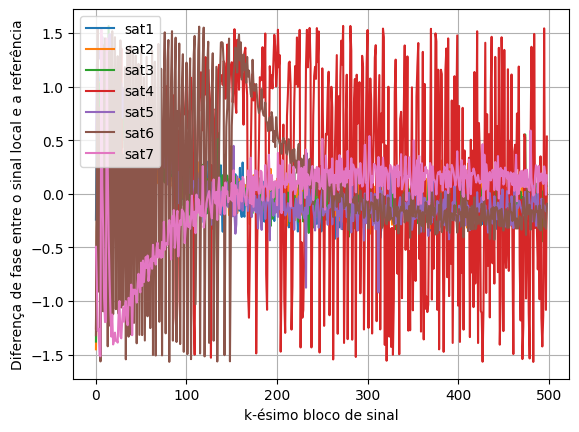

In [48]:
plt.plot(error_signal_phase)
plt.xlabel("k-ésimo bloco de sinal")
plt.ylabel("Diferença de fase entre o sinal local e a referência")
plt.legend(["sat1","sat2","sat3","sat4","sat5","sat6","sat7" ], loc="upper left")
plt.grid(True)

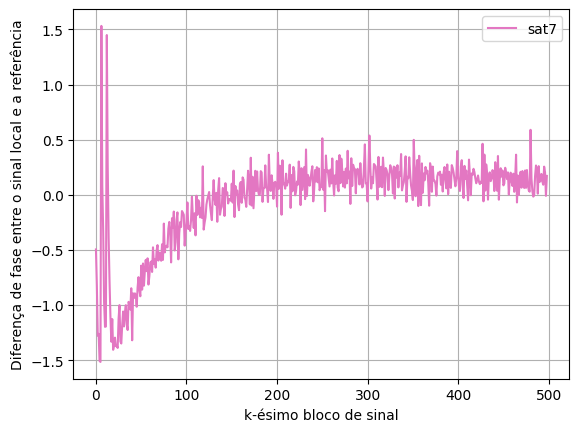

In [84]:
plt.plot(error_signal_phase[:,6],'tab:pink')
plt.xlabel("k-ésimo bloco de sinal")
plt.ylabel("Diferença de fase entre o sinal local e a referência")
plt.legend(["sat7"], loc="upper right")
plt.grid(True)

In [13]:
#erro do delay do matlab
erro_mat = loadmat('erro_delay.mat')
erro = erro_mat["error_signal_delay"]

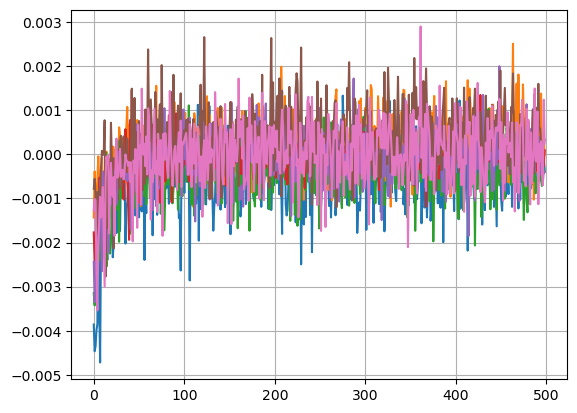

In [15]:
plt.plot(erro)
plt.grid(True)